# ***Cell 1: Enhanced Imports and Setup***

In [1]:
pip install "protobuf<6.30"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2

In [2]:
# Cell 1: Enhanced setup with better error handling
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)

2025-12-27 12:50:04.404430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766839804.568327      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766839804.616373      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU Available: True


# **Cell 2: Configuration and Data Visualization**

✅ Dataset found at: /kaggle/input/jujubis-leaf/augmenteddataset_advanced
📁 Found 5 classes: ['Anthracnose', 'Healthy', 'Insect Damage', 'Powdery Mildew', 'Yellow Leaf']

Displaying one sample image from each class...


I0000 00:00:1766839831.493463      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766839831.494151      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


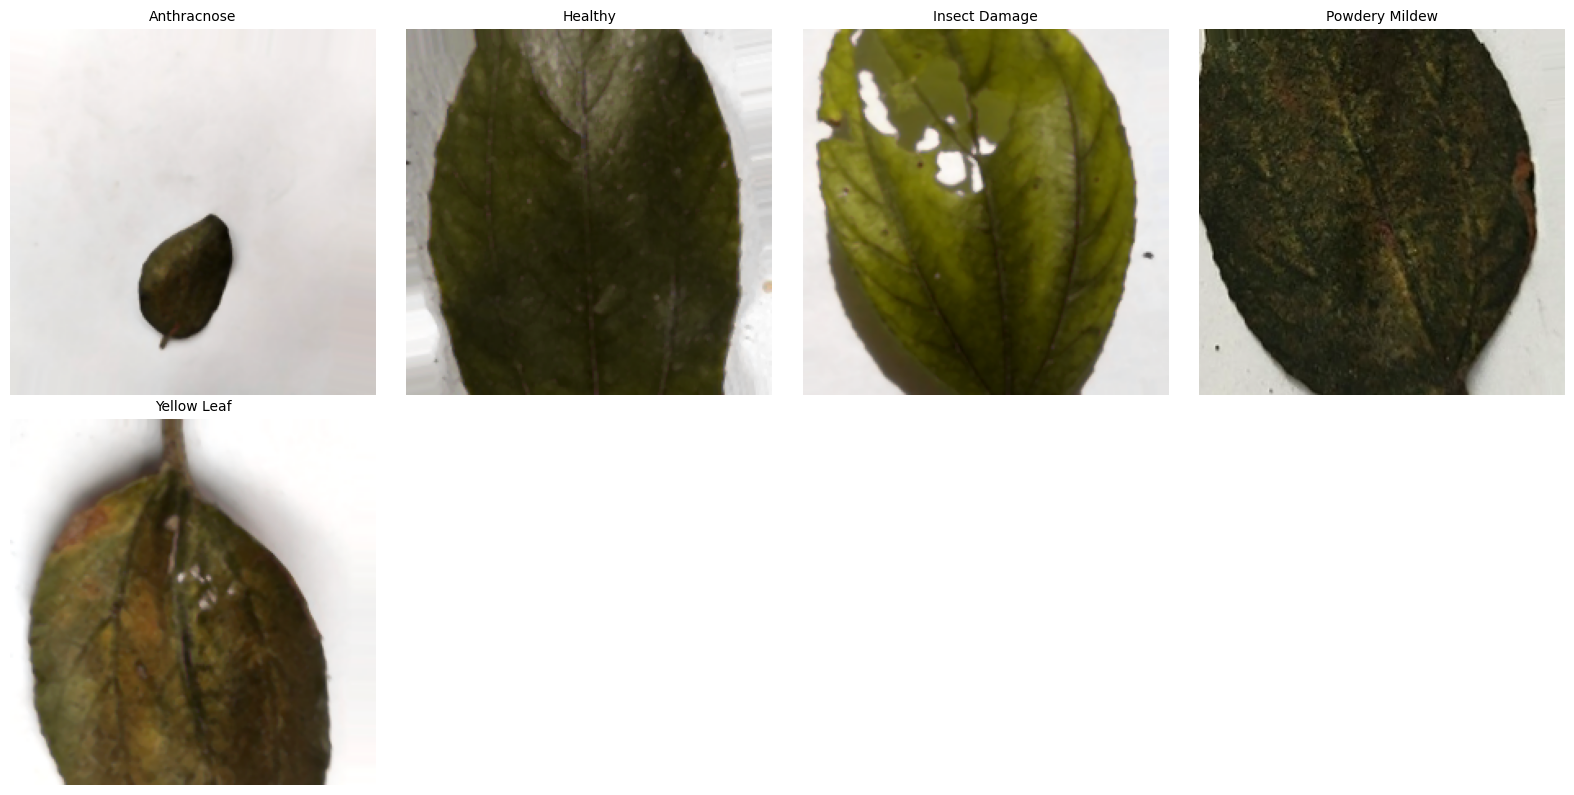

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

# --- Centralized Configuration ---
CONFIG = {
    # Data and Path Settings
    "data_dir": "/kaggle/input/jujubis-leaf/augmenteddataset_advanced", 
    
    # Model and Image Settings
    "image_size": (224, 224),
    "num_classes": 4, 
    "dropout_rate": 0.4,
    
    # Training Settings
    "batch_size": 32,
    "epochs": 100, # Set high, EarlyStopping will find the best
    "learning_rate": 0.0001,
    
    # Data Splitting (70-15-15)
    "train_split": 0.7,
    "val_split": 0.15,
    
    # Advanced Preprocessing Parameters
    "denoise_kernel_size": 3,
    "clahe_clip_limit": 2.0,
    "clahe_grid_size": (8, 8),
    
    # Callbacks & Reproducibility
    "patience": 10, # Patience for EarlyStopping
    "seed": 42,
    
    # --- ADD THESE TWO LINES ---
    "model_save_path": "/kaggle/working/best_model.keras",
    "history_save_path": "/kaggle/working/training_history.pkl"
    
}
# --- Set Random Seeds for Reproducibility ---
tf.random.set_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# --- Verify Dataset Path ---
if not os.path.exists(CONFIG["data_dir"]):
    print(f"❌ Error: Dataset not found at path: {CONFIG['data_dir']}")
    print("Please make sure the dataset is added via 'Add Input'.")
else:
    print(f"✅ Dataset found at: {CONFIG['data_dir']}")
    
    # Automatically find class names by looking at the subdirectories
    class_names = sorted([d for d in os.listdir(CONFIG["data_dir"]) if os.path.isdir(os.path.join(CONFIG["data_dir"], d))])
    
    if not class_names:
        print("❌ Error: No class subdirectories found in the data directory.")
    else:
        # Update num_classes in CONFIG to match the actual number of folders found
        CONFIG["num_classes"] = len(class_names)
        print(f"📁 Found {CONFIG['num_classes']} classes: {class_names}\n")

        # --- Display a Sample Image From Each Class (with Dynamic Grid) ---
        print("Displaying one sample image from each class...")
        
        # --- RECONFIGURED PART: Dynamic Grid Calculation ---
        # This makes the plot adapt to any number of classes automatically.
        cols = 4 
        rows = math.ceil(CONFIG["num_classes"] / cols)
        
        plt.figure(figsize=(cols * 4, rows * 4)) # Figure size adjusts to the grid
        
        for i, class_name in enumerate(class_names):
            class_path = os.path.join(CONFIG["data_dir"], class_name)
            try:
                img_name = os.listdir(class_path)[0]
                img_path = os.path.join(class_path, img_name)
                
                img = tf.io.read_file(img_path)
                img = tf.image.decode_jpeg(img, channels=3)

                # Use the calculated rows and cols for the subplot
                plt.subplot(rows, cols, i + 1)
                plt.imshow(img.numpy().astype("uint8"))
                plt.title(class_name, fontsize=10)
                plt.axis('off')
            
            except (FileNotFoundError, IndexError):
                print(f"⚠️ Warning: Could not find any images in '{class_path}'")

        plt.tight_layout()
        plt.show()


# --- Cell3. Load, Split, and Preprocess the Dataset ---

# --- Cell4.Split Dataset ---

📂 Loading dataset from disk...
Found 16976 files belonging to 5 classes.
✅ Dataset loaded successfully. Found 5 classes: ['Anthracnose', 'Healthy', 'Insect Damage', 'Powdery Mildew', 'Yellow Leaf']

🎨 Visualizing the full preprocessing pipeline...


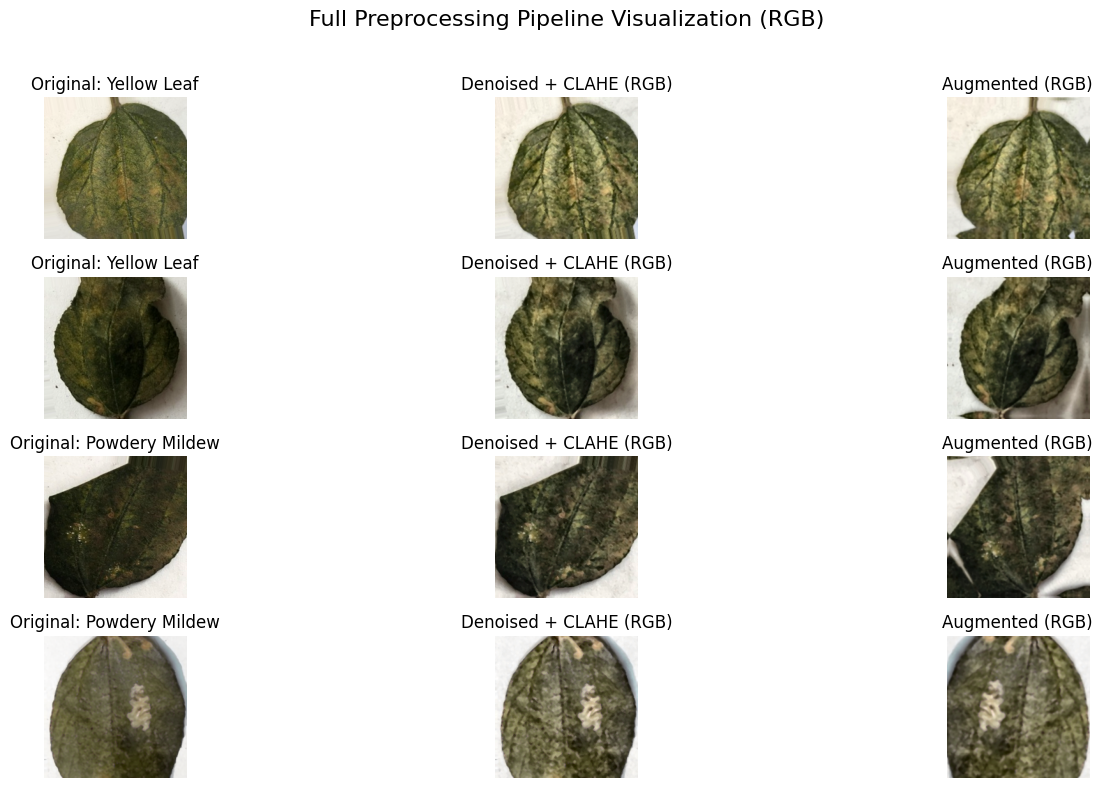


──────────────────────────────────────────────────
📊 Dataset split (Total: 531 batches):
  - Train: 371 batches (69.9%)
  - Val:   79 batches (14.9%)
  - Test:  81 batches (15.3%)
──────────────────────────────────────────────────

🔄 Applying preprocessing and optimizing pipelines...
✅ Cell 2 Complete: Datasets are colour-processed, normalized, and ready!


In [4]:
# ============================================================
# Cell 2: Data Pipeline (Load, Preprocess, Visualize, Split)
#     - OpenCV + CLAHE, keeping RGB colour
# ============================================================

import cv2  # OpenCV for advanced image processing

# ------------------ Step 1: Load Dataset ------------------
print("📂 Loading dataset from disk...")
try:
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        CONFIG["data_dir"],
        shuffle=True,
        image_size=CONFIG["image_size"],
        batch_size=CONFIG["batch_size"],
        label_mode="int",
    )
    class_names = full_dataset.class_names
    CONFIG["num_classes"] = len(class_names)
    print(f"✅ Dataset loaded successfully. Found {CONFIG['num_classes']} classes: {class_names}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    full_dataset = None
    class_names = []

# ------------------ Step 2: Preprocessing Layers & Functions ------------------

# A. Standard Keras layers
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(*CONFIG["image_size"], 3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

# B. OpenCV processing with colour-preserving CLAHE (RGB in -> RGB out)
def apply_opencv_processing(image_tensor):
    """
    Applies denoising and CLAHE using OpenCV while preserving colour.
    Input:  Tensor (H, W, 3) in RGB, values ~ [0, 255]
    Output: Numpy array (H, W, 3) in RGB, dtype float32
    """
    image_np = image_tensor.numpy().astype(np.uint8)

    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    elif image_np.ndim == 3 and image_np.shape[2] == 1:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)

    # RGB -> BGR (OpenCV default)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # BGR -> LAB (L=lightness, A/B=colour)
    lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Denoise L channel
    l_denoised = cv2.medianBlur(l, CONFIG["denoise_kernel_size"])

    # CLAHE on L
    clahe = cv2.createCLAHE(
        clipLimit=CONFIG["clahe_clip_limit"],
        tileGridSize=CONFIG["clahe_grid_size"],
    )
    l_clahe = clahe.apply(l_denoised)

    lab_clahe = cv2.merge((l_clahe, a, b))
    bgr_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    rgb_clahe = cv2.cvtColor(bgr_clahe, cv2.COLOR_BGR2RGB)

    return rgb_clahe.astype(np.float32)

# C. Wrappers for tf.data (batch-wise)
def prepare_train_data(image, label):
    def single_image_py_func(img):
        [processed_img] = tf.py_function(
            func=apply_opencv_processing,
            inp=[img],
            Tout=[tf.float32],
        )
        return processed_img

    image = tf.map_fn(
        single_image_py_func,
        image,
        fn_output_signature=tf.float32,
    )
    image.set_shape([None, *CONFIG["image_size"], 3])

    image = data_augmentation(image, training=True)
    image = normalization_layer(image)
    return image, label

def prepare_val_test_data(image, label):
    def single_image_py_func(img):
        [processed_img] = tf.py_function(
            func=apply_opencv_processing,
            inp=[img],
            Tout=[tf.float32],
        )
        return processed_img

    image = tf.map_fn(
        single_image_py_func,
        image,
        fn_output_signature=tf.float32,
    )
    image.set_shape([None, *CONFIG["image_size"], 3])

    image = normalization_layer(image)
    return image, label

# ------------------ Step 3: Visualize Full Pipeline ------------------
if full_dataset is not None:
    print("\n🎨 Visualizing the full preprocessing pipeline...")
    sample_images, sample_labels = next(iter(full_dataset))

    plt.figure(figsize=(16, 8))
    plt.suptitle("Full Preprocessing Pipeline Visualization (RGB)", fontsize=16)

    for i in range(4):
        image = sample_images[i]

        # Original
        plt.subplot(4, 3, i * 3 + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(f"Original: {class_names[sample_labels[i]]}")
        plt.axis("off")

        # OpenCV
        processed_image = tf.py_function(
            func=apply_opencv_processing,
            inp=[image],
            Tout=[tf.float32],
        )[0]
        plt.subplot(4, 3, i * 3 + 2)
        plt.imshow(processed_image.numpy().astype("uint8"))
        plt.title("Denoised + CLAHE (RGB)")
        plt.axis("off")

        # Augmentation
        augmented_image = data_augmentation(
            tf.expand_dims(processed_image, 0),
            training=True,
        )[0]
        plt.subplot(4, 3, i * 3 + 3)
        plt.imshow(augmented_image.numpy().astype("uint8"))
        plt.title("Augmented (RGB)")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ------------------ Step 4: Split & Map Pipelines ------------------
if full_dataset is not None:
    AUTOTUNE = tf.data.AUTOTUNE
    dataset_size = int(tf.data.experimental.cardinality(full_dataset).numpy())

    train_size = int(CONFIG["train_split"] * dataset_size)
    val_size = int(CONFIG["val_split"] * dataset_size)
    test_size = dataset_size - train_size - val_size

    print("\n" + "─" * 50)
    print(f"📊 Dataset split (Total: {dataset_size} batches):")
    print(f"  - Train: {train_size} batches ({train_size / dataset_size * 100:.1f}%)")
    print(f"  - Val:   {val_size} batches ({val_size / dataset_size * 100:.1f}%)")
    print(f"  - Test:  {test_size} batches ({test_size / dataset_size * 100:.1f}%)")
    print("─" * 50)

    train_ds = full_dataset.take(train_size)
    val_ds = full_dataset.skip(train_size).take(val_size)
    test_ds = full_dataset.skip(train_size + val_size)

    print("\n🔄 Applying preprocessing and optimizing pipelines...")
    train_ds = (
        train_ds
        .map(prepare_train_data, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    val_ds = (
        val_ds
        .map(prepare_val_test_data, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    test_ds = (
        test_ds
        .map(prepare_val_test_data, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

    print("✅ Cell 2 Complete: Datasets are colour-processed, normalized, and ready!")
else:
    raise RuntimeError("full_dataset is None – cannot proceed to training.")


In [5]:
if full_dataset:
    AUTOTUNE = tf.data.AUTOTUNE
    dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()

    # Calculate the size of each split in batches
    train_size = int(CONFIG["train_split"] * dataset_size)
    val_size = int(CONFIG["val_split"] * dataset_size)
    test_size = dataset_size - train_size - val_size # Correctly calculates the remaining 15%

    # --- Detailed Split Summary ---
    print("\n" + "─"*50)
    print(f"📊 Dataset split (Total: {dataset_size} batches):")
    print(f"  - Train: {train_size} batches ({train_size/dataset_size*100:.1f}%)")
    print(f"  - Val:   {val_size} batches ({val_size/dataset_size*100:.1f}%)")
    print(f"  - Test:  {test_size} batches ({test_size/dataset_size*100:.1f}%)")
    print("─"*50)

    # Perform the split using .take() and .skip()
    train_ds = full_dataset.take(train_size)
    val_ds = full_dataset.skip(train_size).take(val_size)
    test_ds = full_dataset.skip(train_size + val_size)

    print("\n🔄 Applying preprocessing and optimizing pipelines...")

    # Apply the combined preprocessing function to each dataset
    train_ds = train_ds.map(prepare_train_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.map(prepare_val_test_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(prepare_val_test_data, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

    print("✅ All datasets are now fully preprocessed and ready for training!")


──────────────────────────────────────────────────
📊 Dataset split (Total: 531 batches):
  - Train: 371 batches (69.9%)
  - Val:   79 batches (14.9%)
  - Test:  81 batches (15.3%)
──────────────────────────────────────────────────

🔄 Applying preprocessing and optimizing pipelines...
✅ All datasets are now fully preprocessed and ready for training!


# Cell 5: Build Model (VGG16 with Transfer Learning)


In [6]:
# Cell 3: Build Model (VGG16 with Transfer Learning)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# --- 1. Load Pre-Trained Base Model (VGG16) ---
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   # Use CONFIG to get the image_size
                   input_shape=(CONFIG["image_size"][0], CONFIG["image_size"][1], 3))

# --- 2. Freeze the Base Model ---
base_model.trainable = False

# --- 3. Build the Custom Top Layer ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# Use CONFIG to get the dropout_rate
x = Dropout(CONFIG["dropout_rate"])(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
# Use CONFIG to get the dropout_rate
x = Dropout(CONFIG["dropout_rate"])(x)
# Use CONFIG to get the num_classes
output = Dense(CONFIG["num_classes"], activation='softmax')(x)

# --- 4. Create the Final Model ---
model = Model(inputs=base_model.input, outputs=output)

print(f"✅ VGG16 model architecture created with 'imagenet' weights.")
# We will print the summary in the next cell after compilation.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ VGG16 model architecture created with 'imagenet' weights.


# --- # Cell 6: Advanced Model Compilation (Kaggle-Ready) ---

In [8]:
# Cell 4: Compile Model (Corrected)

import tensorflow as tf
from tensorflow.keras.optimizers import AdamW

# --- 1. Define Optimizer ---
OPTIMIZER = AdamW(learning_rate=CONFIG["learning_rate"], weight_decay=1e-5)

# --- 2. Define Metrics for Deeper Insight ---
# --- THIS IS THE FIX ---
# We remove Precision and Recall here to avoid the graph error.
# We will calculate them manually after training.
METRICS = ['accuracy']

# --- 3. Compile the Model ---
print("🔧 Compiling model...")
model.compile(
    optimizer=OPTIMIZER,
    loss='sparse_categorical_crossentropy',
    metrics=METRICS,
    jit_compile=False  # Keep this to disable XLA
)

print(f"✅ Model compiled successfully (JIT/XLA Disabled).")
print(f"   - Optimizer: AdamW")
print(f"   - Learning Rate: {CONFIG['learning_rate']}")
print(f"   - Loss Function: sparse_categorical_crossentropy")

# --- 4. Display Model Summary ---
print("\n" + "="*60)
print(" " * 22 + "MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)

🔧 Compiling model...
✅ Model compiled successfully (JIT/XLA Disabled).
   - Optimizer: AdamW
   - Learning Rate: 0.0001
   - Loss Function: sparse_categorical_crossentropy

                      MODEL ARCHITECTURE


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,04

 Total params: 14,984,005 (57.16 MB)

 Trainable params: 267,269 (1.02 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

# --- 7.Define Callbacks, Train Model, and Save History ---

In [9]:
# Cell 5: Define Callbacks, Train Model, and Save History (Corrected)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle

# --- 1. Define Advanced Callbacks ---

# 🎯 ModelCheckpoint: Saves the best model (monitoring val_accuracy)
model_checkpoint = ModelCheckpoint(
    filepath=CONFIG["model_save_path"],
    monitor='val_accuracy',
    save_best_only=True,
    mode='max', # 'max' for accuracy
    verbose=1
)

# 📉 ReduceLROnPlateau: Reduces LR if val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 🛑 EarlyStopping: Stops training if val_loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=CONFIG["patience"],
    restore_best_weights=True,
    verbose=1
)

CALLBACKS_LIST = [model_checkpoint, reduce_lr, early_stopping]

# --- 2. Train the Model ---
print("\n" + "🔥"*20)
print(" " * 12 + "STARTING MODEL TRAINING")
print("🔥"*20)
print(f"Using Epochs: {CONFIG['epochs']} (with EarlyStopping)")
print(f"Using Patience: {CONFIG['patience']}")
print(f"Using LR: {CONFIG['learning_rate']} (with ReduceLROnPlateau)")
print(f"Best model will be saved to: {CONFIG['model_save_path']}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["epochs"],
    callbacks=CALLBACKS_LIST,
    verbose=1
)
print("✅ Training finished!")

# --- 3. Evaluate the Best Model ---
print("\n📊 Evaluating best model on the test set...")
# --- THIS IS THE FIX ---
# model.evaluate now only returns loss and accuracy (metrics[0] and metrics[1])
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print("\n" + "="*50)
print(" " * 16 + "FINAL PERFORMANCE")
print("="*50)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("="*50)
print("(Precision & Recall will be calculated in the next cell.)")

# --- 4. Save Training History ---
print(f"\n📚 Saving training history to {CONFIG['history_save_path']}...")
with open(CONFIG['history_save_path'], 'wb') as f:
    pickle.dump(history.history, f)
print("✅ History saved successfully.")


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
            STARTING MODEL TRAINING
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
Using Epochs: 100 (with EarlyStopping)
Using Patience: 10
Using LR: 0.0001 (with ReduceLROnPlateau)
Best model will be saved to: /kaggle/working/best_model.keras
Epoch 1/100


I0000 00:00:1766839903.363891     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.4601 - loss: 1.5844
Epoch 1: val_accuracy improved from -inf to 0.71321, saving model to /kaggle/working/best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 160s 410ms/step - accuracy: 0.4604 - loss: 1.5835 - val_accuracy: 0.7132 - val_loss: 0.7664 - learning_rate: 1.0000e-04
Epoch 2/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6621 - loss: 0.9512
Epoch 2: val_accuracy improved from 0.71321 to 0.78441, saving model to /kaggle/working/best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 77s 208ms/step - accuracy: 0.6621 - loss: 0.9510 - val_accuracy: 0.7844 - val_loss: 0.5722 - learning_rate: 1.0000e-04
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6937 - loss: 0.8498
Epoch 3: val_accuracy improved from 0.78441 to 0.81052, saving model to /kaggle/working/best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 77s 208ms/step - accuracy: 0.6937 - loss: 0.8497 - val_accuracy: 0.8105 - val_loss: 0.5226 - learning_rate:

# Cell 9: Detailed Evaluation and Confusion Matrix

Loading best model from: /kaggle/working/best_model.keras...
✅ Best model loaded successfully.

Evaluating model on the test dataset...

               TEST SET PERFORMANCE
Test Loss:     0.1636
Test Accuracy: 94.33%

📊 Generating detailed classification report...
                precision    recall  f1-score   support

   Anthracnose       0.93      0.91      0.92       517
       Healthy       0.97      0.99      0.98       326
 Insect Damage       0.99      0.95      0.97       512
Powdery Mildew       0.91      0.96      0.93       517
   Yellow Leaf       0.93      0.93      0.93       704

      accuracy                           0.94      2576
     macro avg       0.95      0.95      0.95      2576
  weighted avg       0.94      0.94      0.94      2576

🔲 Plotting Confusion Matrix...


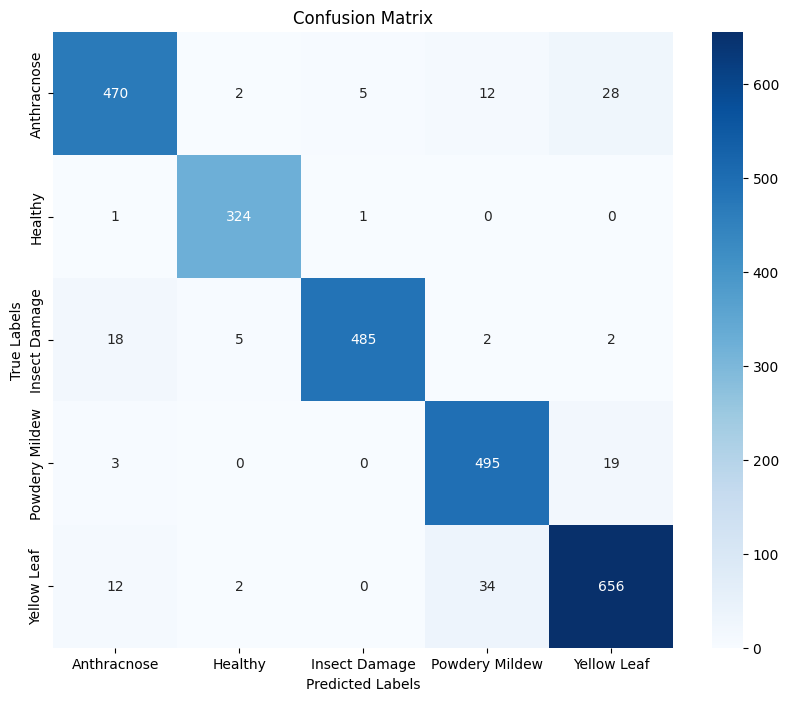

In [11]:
# Cell 6: Final Model Evaluation on Test Set (Corrected)

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load the Best Saved Model ---
print(f"Loading best model from: {CONFIG['model_save_path']}...")
model = tf.keras.models.load_model(CONFIG["model_save_path"])
print("✅ Best model loaded successfully.")

# --- 2. Evaluate for Loss and Accuracy ---
print("\nEvaluating model on the test dataset...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)

print("\n" + "="*50)
print(" " * 15 + "TEST SET PERFORMANCE")
print("="*50)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("="*50)

# --- 3. Generate Detailed Report and Predictions ---
print("\n📊 Generating detailed classification report...")
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict_on_batch(images))

# --- THIS IS THE FIX ---
# Convert the prediction lists to NumPy arrays for slicing
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
# ---------------------

y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

# --- 4. Plot Confusion Matrix ---
print("🔲 Plotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Cell 10: Plot Training and Validation Curves


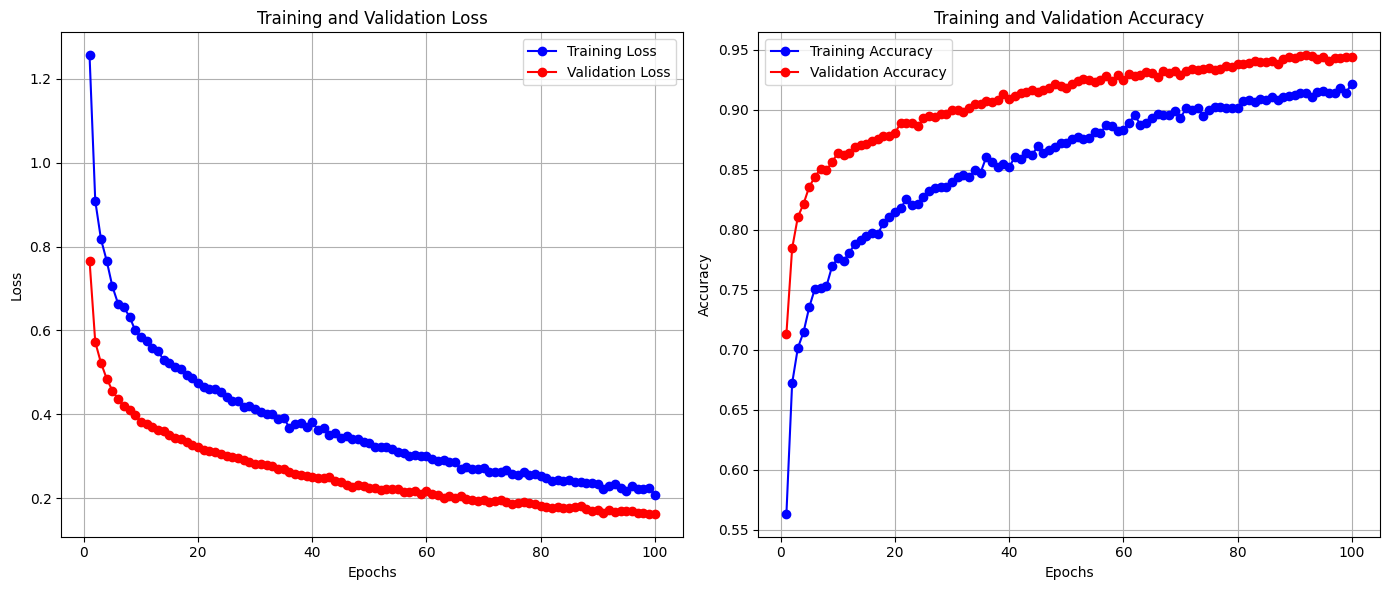

In [12]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plots the training and validation loss/accuracy curves
    from a Keras history object.
    """
    # Extract data from the history object
    try:
        train_losses = history.history['loss']
        val_losses = history.history['val_loss']
        train_accuracies = history.history['accuracy']
        val_accuracies = history.history['val_accuracy']
    except KeyError as e:
        print(f"Error: Could not find key {e} in history.history.")
        print("Available keys:", history.history.keys())
        return

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # --- Loss Subplot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy Subplot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjusts plots for better layout
    plt.show()

# --- Call the function ---
# 'history' is the variable returned by model.fit() in Cell 5
if 'history' in locals():
    plot_training_curves(history)
else:
    print("⚠️ 'history' object not found. Please run the training cell (Cell 5) first.")

# Cell 11: Plot Multi-Class ROC Curves


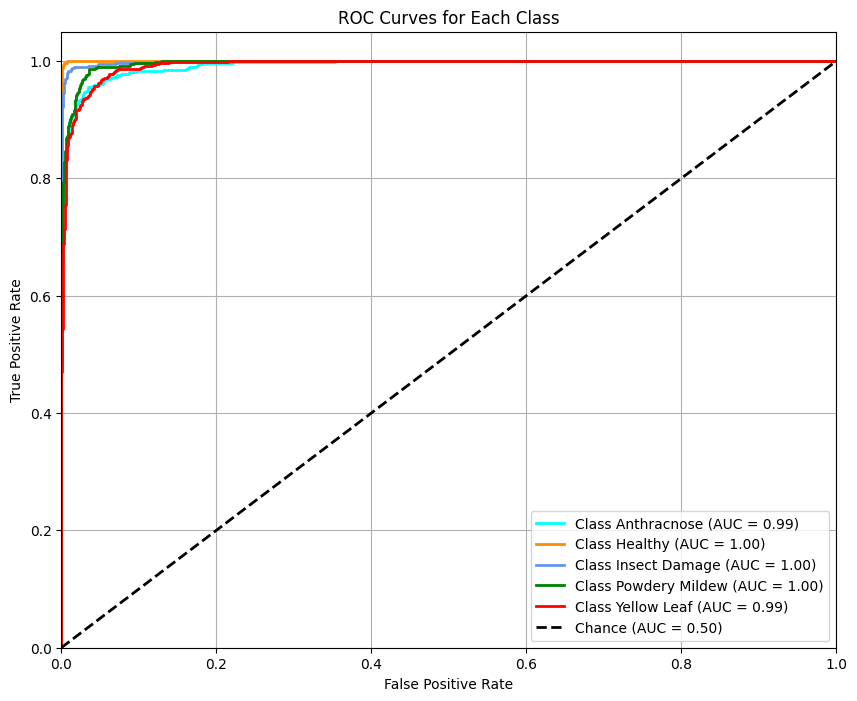

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_curves(y_true, y_pred_probs, class_names):
    """
    Plots the ROC curves for each class in a multi-class setting.
    """
    n_classes = len(class_names)

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Check if binarization worked (it should have n_classes columns)
    if y_true_bin.shape[1] != n_classes:
        # This handles a rare case where a class might be missing
        y_true_bin = label_binarize(y_true, classes=np.arange(max(y_true) + 1))
        # Ensure it has n_classes columns, padding if necessary
        if y_true_bin.shape[1] < n_classes:
            padding = np.zeros((y_true_bin.shape[0], n_classes - y_true_bin.shape[1]))
            y_true_bin = np.hstack((y_true_bin, padding))

    # Dictionaries to store ROC data
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    # Plot the "chance" line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# --- Call the function ---
# We use the variables generated in Cell 6
if 'y_true' in locals() and 'y_pred_probs' in locals():
    plot_roc_curves(y_true, y_pred_probs, class_names)
else:
    print("⚠️ Variables 'y_true' and 'y_pred_probs' not found.")
    print("Please run the evaluation cell (Cell 6) first.")

# Cell 12: Plot Multi-Class Precision-Recall Curves

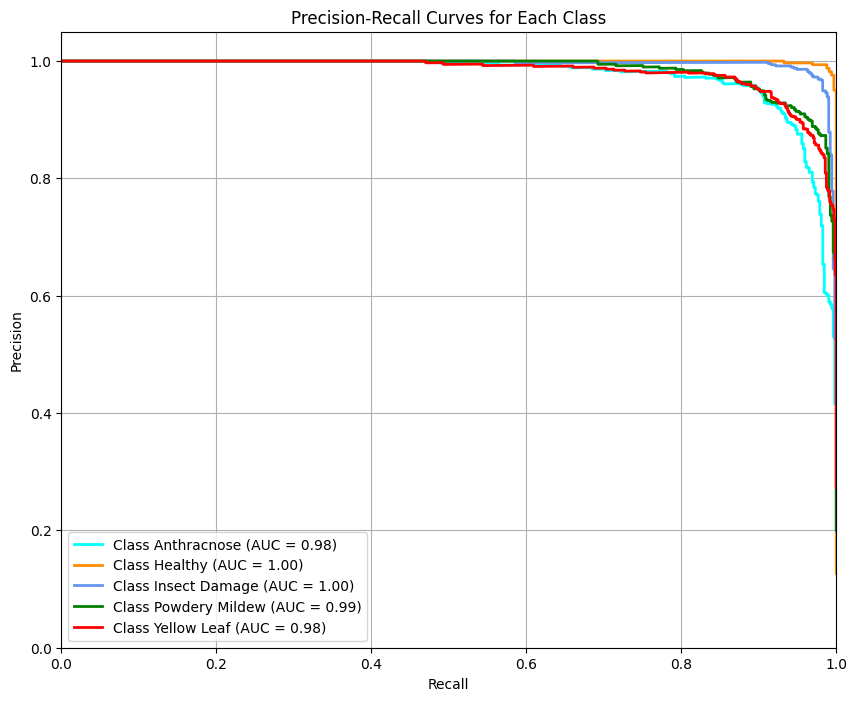

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
from itertools import cycle

def plot_precision_recall_curves(y_true, y_pred_probs, class_names):
    """
    Plots the Precision-Recall curves for each class in a multi-class setting.
    """
    n_classes = len(class_names)

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    # Check if binarization worked (it should have n_classes columns)
    if y_true_bin.shape[1] != n_classes:
        # This handles a rare case where a class might be missing
        y_true_bin = label_binarize(y_true, classes=np.arange(max(y_true) + 1))
        # Ensure it has n_classes columns, padding if necessary
        if y_true_bin.shape[1] < n_classes:
            padding = np.zeros((y_true_bin.shape[0], n_classes - y_true_bin.shape[1]))
            y_true_bin = np.hstack((y_true_bin, padding))

    # Dictionaries to store PR data
    precision = dict()
    recall = dict()
    pr_auc = dict()

    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

    for i, color in zip(range(n_classes), colors):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        # Note: AUC for PR curve uses recall (x) and precision (y)
        pr_auc[i] = auc(recall[i], precision[i])
        plt.plot(recall[i], precision[i], color=color, lw=2,
                 label=f'Class {class_names[i]} (AUC = {pr_auc[i]:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Each Class')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# --- Call the function ---
# We use the variables generated in Cell 6
if 'y_true' in locals() and 'y_pred_probs' in locals():
    plot_precision_recall_curves(y_true, y_pred_probs, class_names)
else:
    print("⚠️ Variables 'y_true' and 'y_pred_probs' not found.")
    print("Please run the evaluation cell (Cell 6) first.")

# Cell 13: Class-wise Accuracy Bar Chart


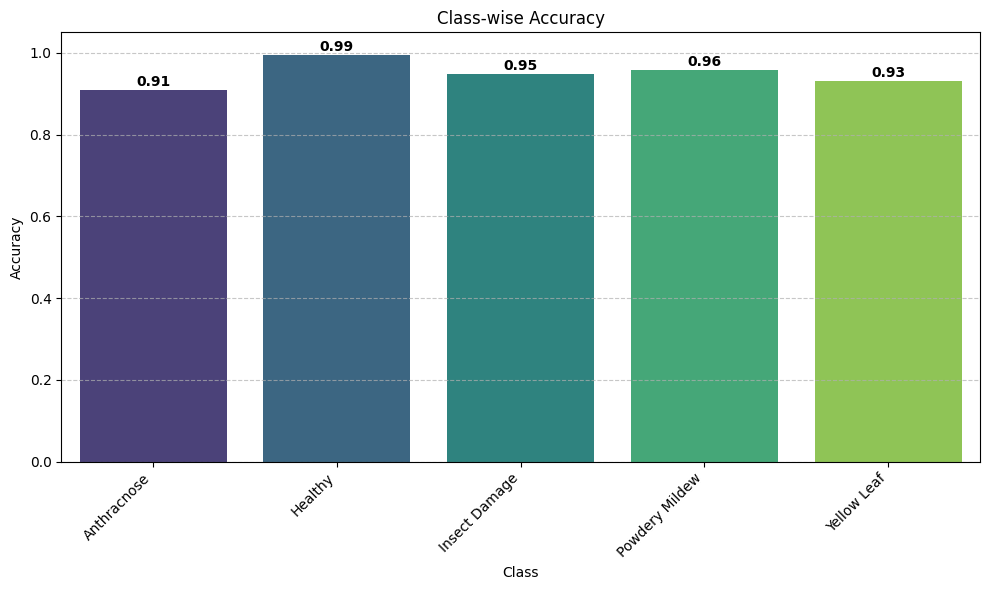

In [15]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

def plot_class_accuracy(y_true, y_pred, class_names):
    """
    Calculates and plots the accuracy for each individual class.
    """
    class_acc = []
    n_classes = len(class_names)

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for i in range(n_classes):
        # Find all samples that belong to the current class 'i'
        idx = np.where(y_true == i)[0]

        if len(idx) > 0:
            # Calculate accuracy just for those samples
            class_acc.append(accuracy_score(y_true[idx], y_pred[idx]))
        else:
            # No samples of this class in the test set
            class_acc.append(0.0)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_acc, palette='viridis')
    plt.title('Class-wise Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05) # Set ylim to 1.05 for better visibility
    plt.xticks(rotation=45, ha='right')

    # Add accuracy labels on top of each bar
    for i, acc in enumerate(class_acc):
        plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- Call the function ---
# We use the variables generated in Cell 6
if 'y_true' in locals() and 'y_pred' in locals():
    plot_class_accuracy(y_true, y_pred, class_names)
else:
    print("⚠️ Variables 'y_true' and 'y_pred' not found.")
    print("Please run the evaluation cell (Cell 6) first.")

# Cell 14: Visualize Sample Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


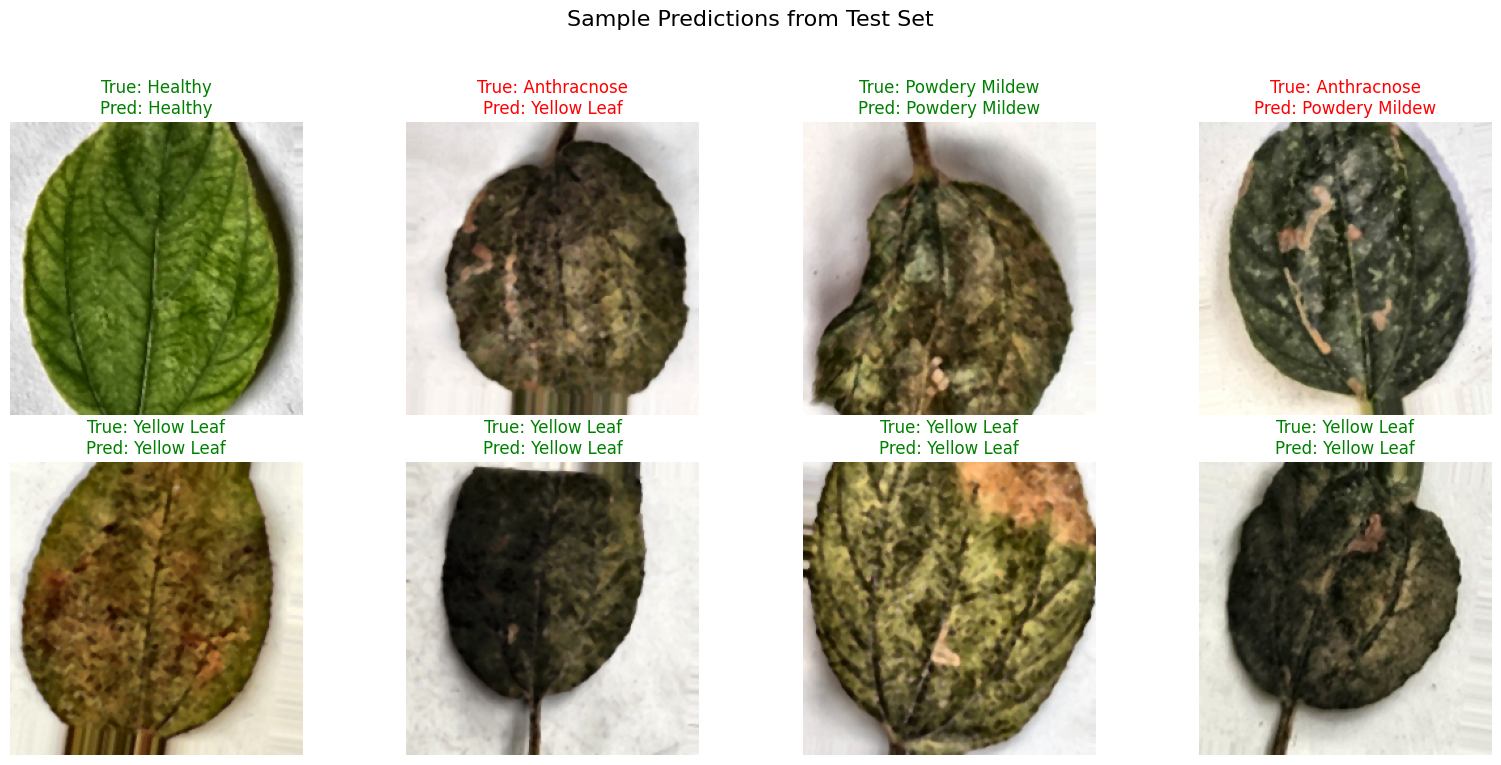

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(test_dataset, class_names, num_samples=8):
    """
    Fetches a batch from the test dataset, runs predictions,
    and visualizes the results.
    """
    # 1. Get one batch of test images and labels
    images, labels = next(iter(test_dataset))

    # 2. Get model predictions
    pred_probs = model.predict(images)
    preds = np.argmax(pred_probs, axis=1)

    # Convert labels tensor to numpy array
    labels = labels.numpy()

    # 3. Plot the results
    plt.figure(figsize=(16, 8))
    plt.suptitle("Sample Predictions from Test Set", fontsize=16)

    for i in range(num_samples):
        if i >= len(labels):
            break # Stop if the batch is smaller than num_samples

        plt.subplot(2, 4, i + 1)

        # 'images[i]' is a 0-1 float tensor, imshow can plot this directly.
        # This shows the Denoised + CLAHE image the model actually saw.
        plt.imshow(images[i])

        # Get the string names for labels
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]

        # Set title color to green for correct, red for incorrect
        color = "green" if true_label == pred_label else "red"

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

# --- Call the function ---
# We use the 'test_ds' and 'class_names' variables
if 'test_ds' in locals():
    visualize_predictions(test_ds, class_names, num_samples=8)
else:
    print("⚠️ 'test_ds' not found. Please run the data pipeline (Cell 2) first.")

Grabbing one batch to find a sample for each class...
Found 5 unique classes in this batch.

Generating LIME explanation for class: Anthracnose... (this may take a minute)


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

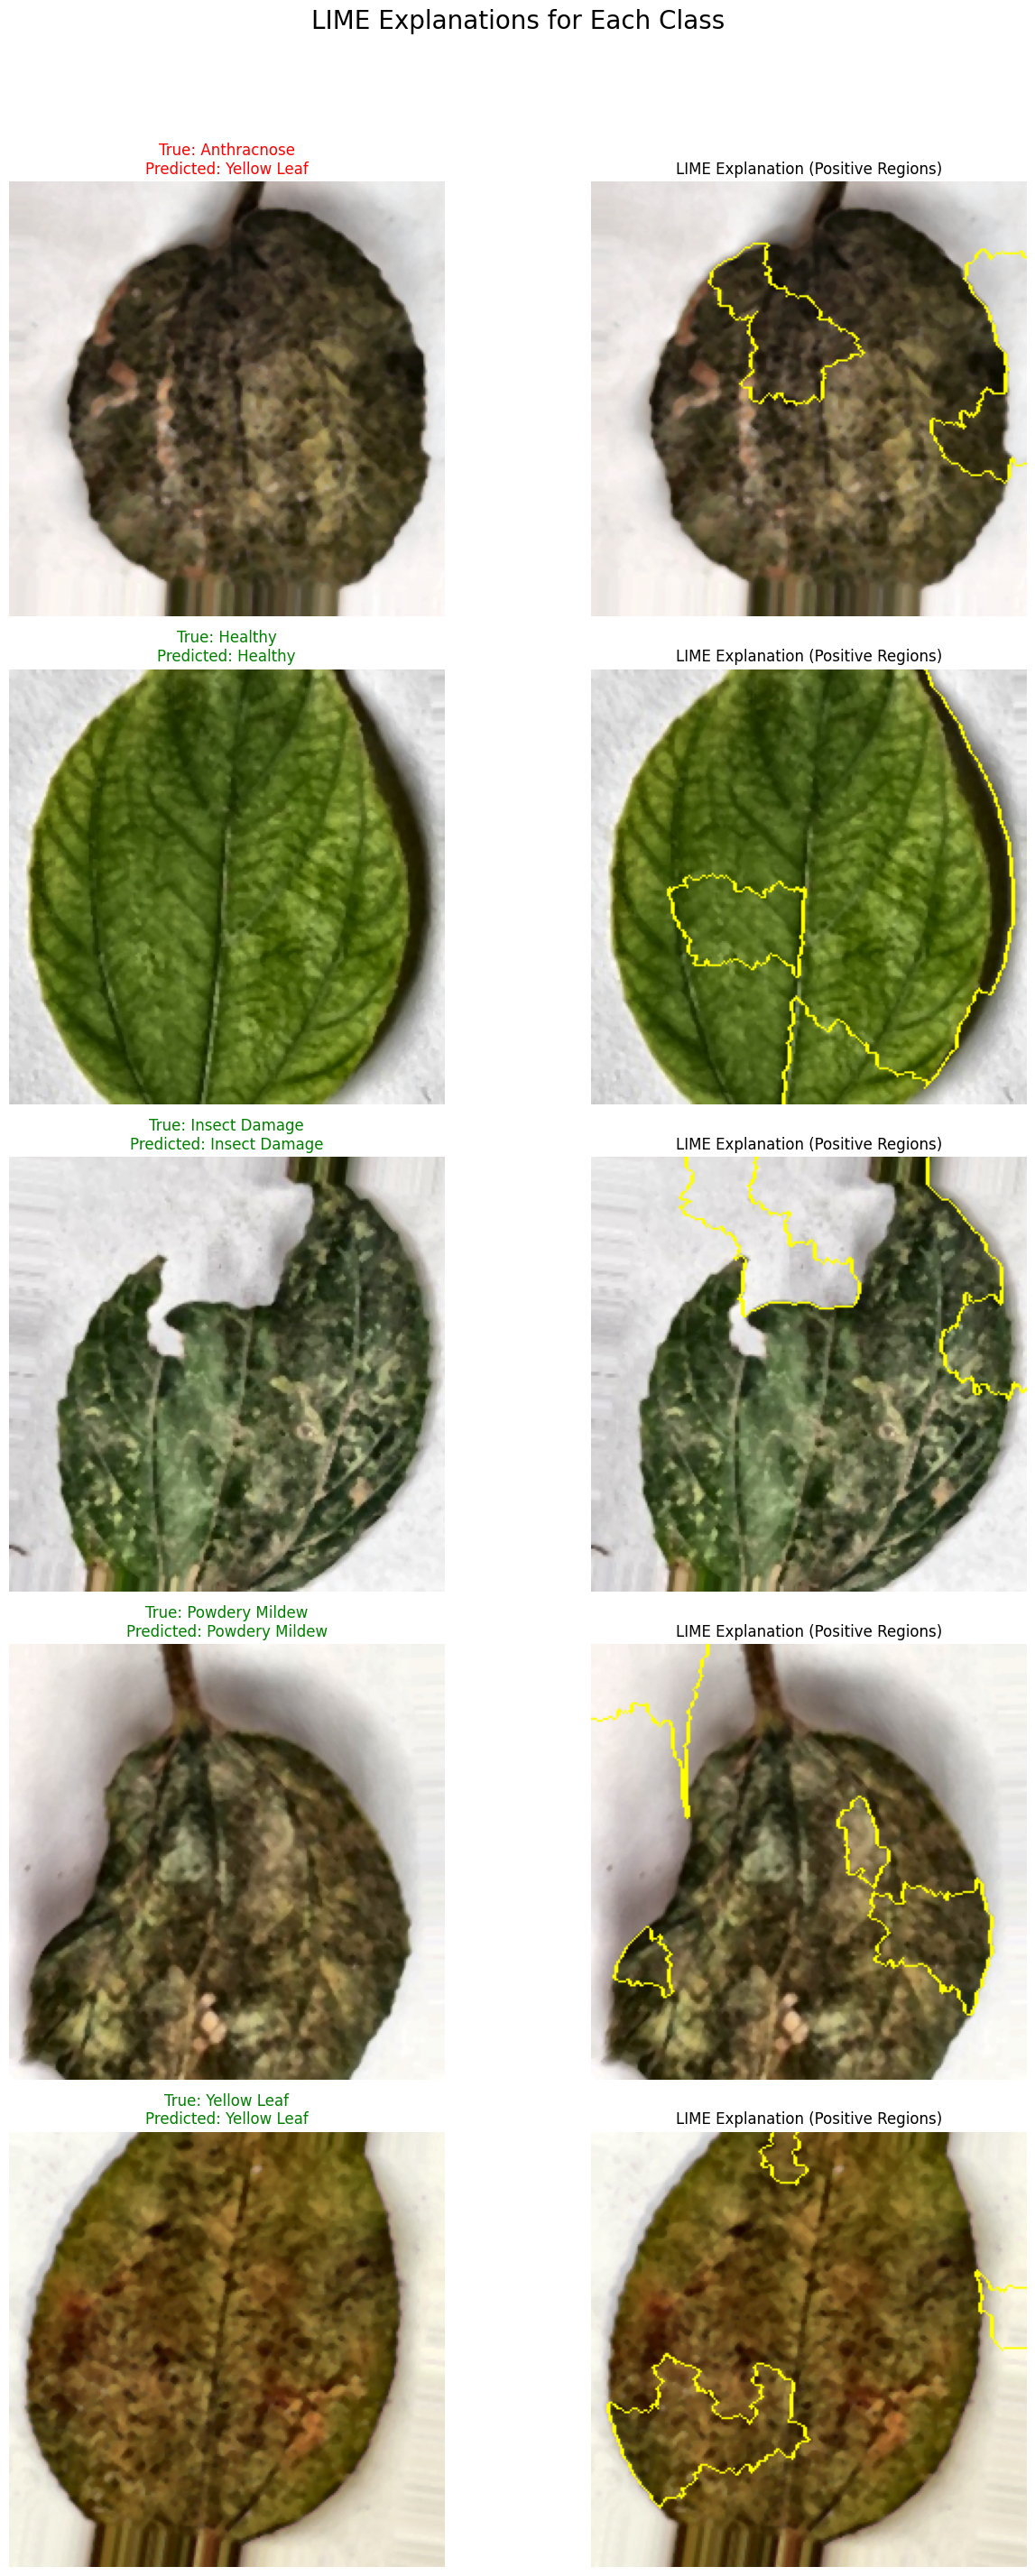

In [17]:
# Cell 15: LIME (Local Interpretable Model-agnostic Explanations) for Each Class

!pip install lime -q

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Define the Predictor Function (No changes) ---
def lime_predictor_fn(images_np):
    return model.predict(images_np)

# --- 2. Get One Sample Image For Each Class ---
print("Grabbing one batch to find a sample for each class...")
# Get one batch from the test set
images, labels = next(iter(test_ds))
labels_np = labels.numpy()

# Find the unique classes in this batch and the first index for each
unique_classes, first_indices = np.unique(labels_np, return_index=True)

print(f"Found {len(unique_classes)} unique classes in this batch.")

# --- 3. Create the LIME Explainer (No changes) ---
explainer = lime_image.LimeImageExplainer()

# --- 4. Generate and Plot Explanations in a Loop ---
# We will plot 2 images per class (Original + LIME)
cols = 2
rows = len(unique_classes)
plt.figure(figsize=(cols * 7, rows * 6))
plt.suptitle("LIME Explanations for Each Class", fontsize=20)

for i, class_index in enumerate(unique_classes):

    # Get the image and label at the index we found
    image_index = first_indices[i]
    image_to_explain = images[image_index].numpy()
    label_to_explain = labels_np[image_index]

    print(f"\nGenerating LIME explanation for class: {class_names[label_to_explain]}... (this may take a minute)")

    # --- Run the LIME explanation ---
    explanation = explainer.explain_instance(
        image_to_explain,
        lime_predictor_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000 # Number of predictions LIME will run
    )

    # --- Get the explanation image and mask ---
    pred_class_index = explanation.top_labels[0]
    pred_class_name = class_names[pred_class_index]
    true_class_name = class_names[label_to_explain]
    color = "green" if true_class_name == pred_class_name else "red"

    # Get the mask for the top prediction, highlighting positive features
    temp, mask = explanation.get_image_and_mask(
        pred_class_index,
        positive_only=True,   # Show only segments that SUPPORT this prediction
        num_features=5,       # Show the top 5 most important segments
        hide_rest=False         # Show the rest of the image
    )

    # --- Plot the original (preprocessed) image ---
    ax = plt.subplot(rows, cols, i * 2 + 1)
    ax.imshow(image_to_explain)
    ax.set_title(f"True: {true_class_name}\nPredicted: {pred_class_name}", color=color, fontsize=12)
    ax.axis('off')

    # --- Plot the LIME explanation ---
    ax = plt.subplot(rows, cols, i * 2 + 2)
    ax.imshow(mark_boundaries(temp, mask))
    ax.set_title("LIME Explanation (Positive Regions)", fontsize=12)
    ax.axis('off')

print("\n✅ All LIME explanations complete.")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Found last conv layer: block5_conv3
Grabbing one batch to find a sample for each class...
Found 5 unique classes in this batch.


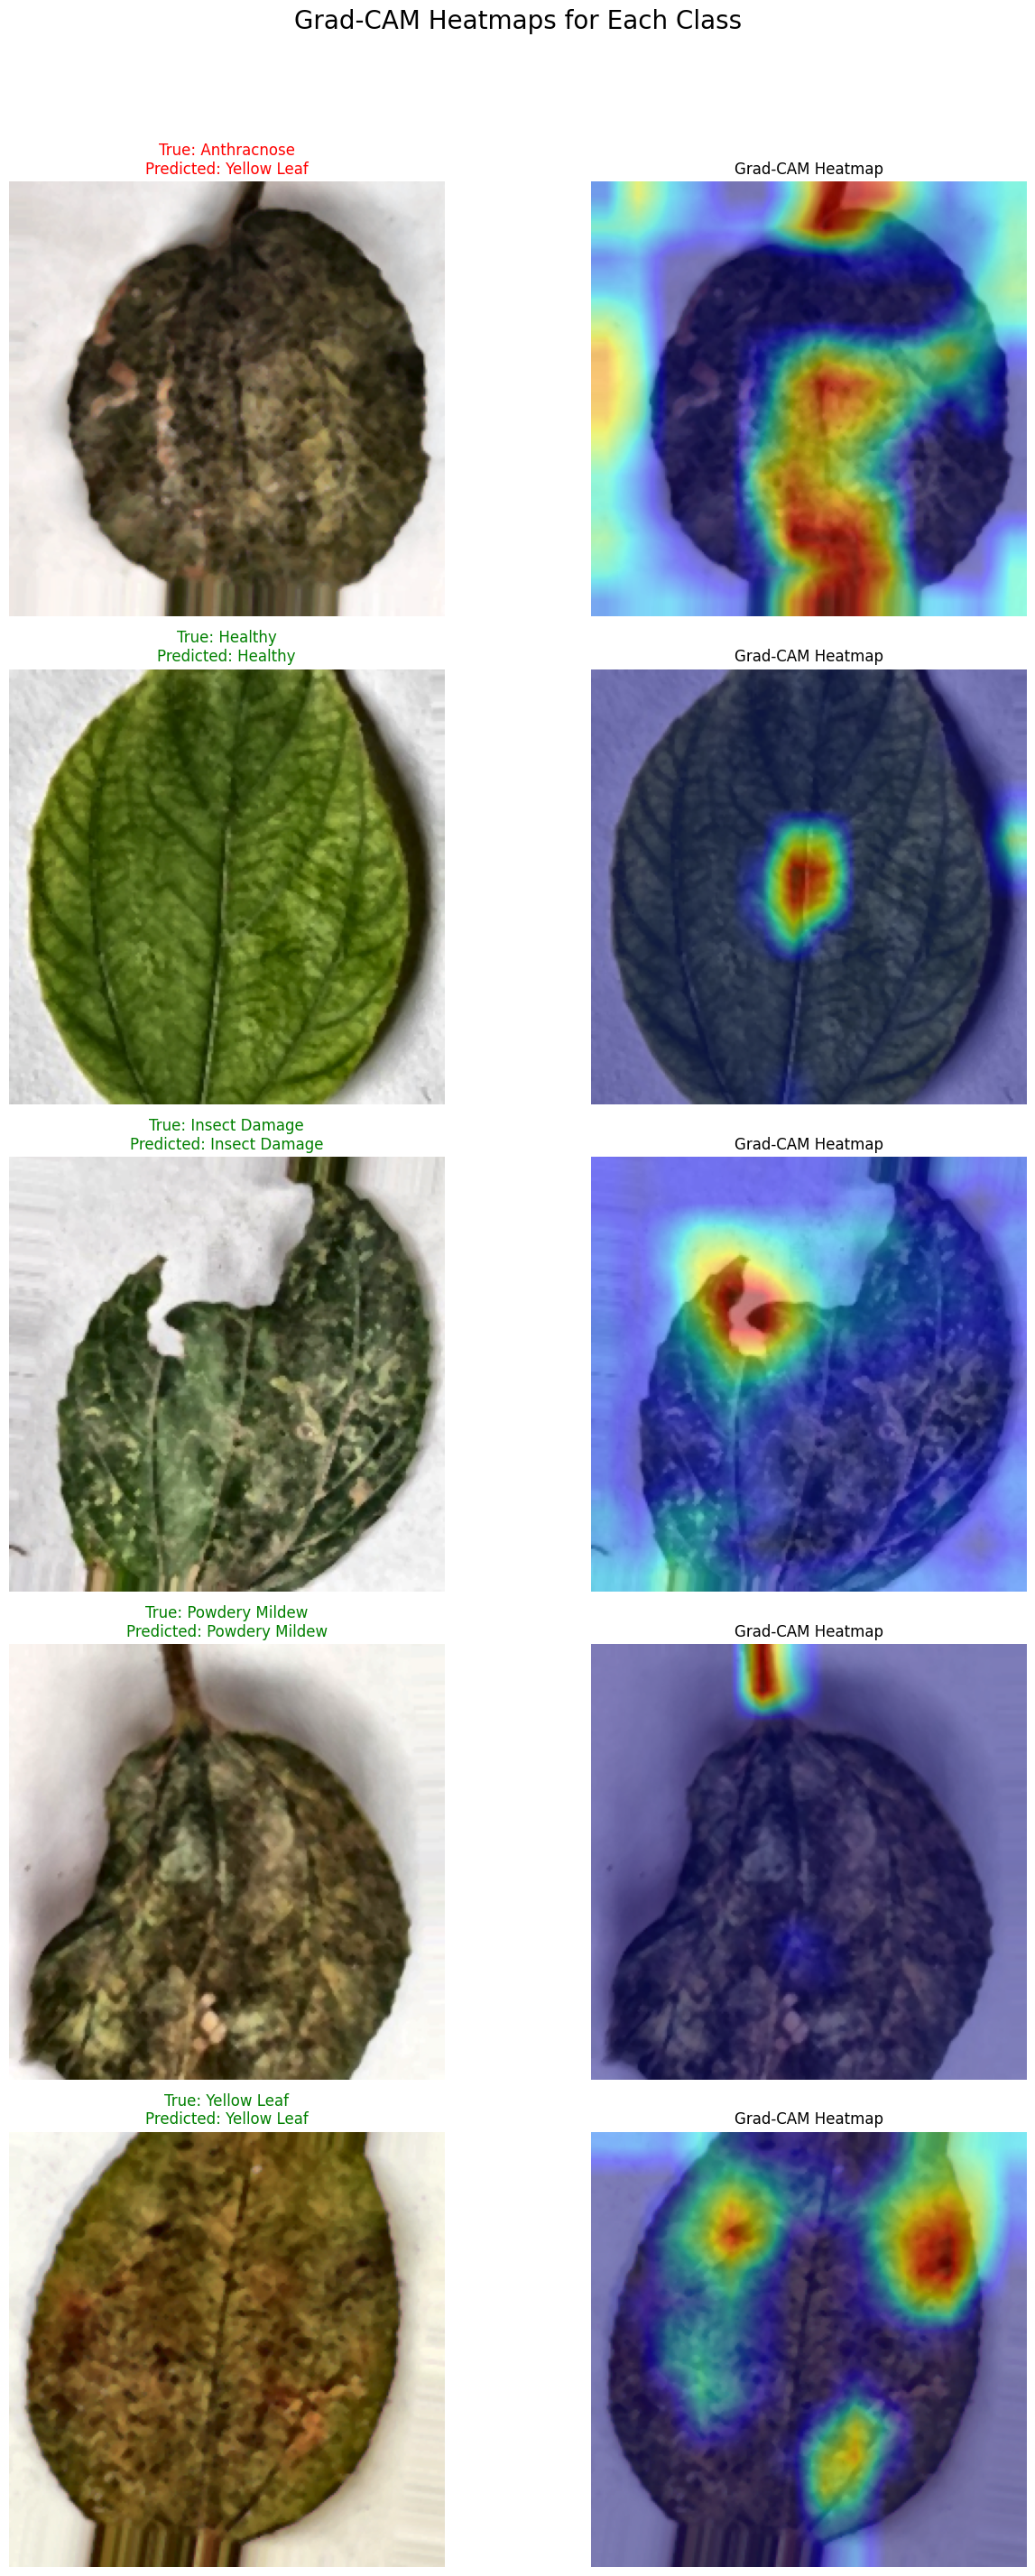

In [19]:
# Cell 16: Grad-CAM for Each Class (Corrected)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 # We need OpenCV to resize the heatmap

# --- 1. Helper Function to Create the Heatmap (No changes) ---
def make_gradcam_heatmap(image, model, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap for a given image and model.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        inputs = tf.expand_dims(image, axis=0)
        (conv_outputs, predictions) = grad_model(inputs)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap.numpy(), pred_index.numpy()

# --- 2. Find the Last Convolutional Layer (No changes) ---
last_conv_layer_name = ""
for layer in reversed(base_model.layers):
    if "conv" in layer.name:
        last_conv_layer_name = layer.name
        break

print(f"Found last conv layer: {last_conv_layer_name}")

# --- 3. Get One Sample Image For Each Class ---
print("Grabbing one batch to find a sample for each class...")
# Get one batch from the test set (preprocessed and normalized)
images, labels = next(iter(test_ds))
labels_np = labels.numpy()

# Find the unique classes in this batch and the first index for each
unique_classes, first_indices = np.unique(labels_np, return_index=True)

print(f"Found {len(unique_classes)} unique classes in this batch.")

# --- 4. Generate and Plot Heatmaps in a Loop ---
# We will plot 2 images per class (Original + Heatmap)
cols = 2
rows = len(unique_classes)
plt.figure(figsize=(cols * 7, rows * 6))
plt.suptitle("Grad-CAM Heatmaps for Each Class", fontsize=20)

for i, class_index in enumerate(unique_classes):

    # Get the image and label at the index we found
    image_index = first_indices[i]
    image_to_explain = images[image_index]
    label_to_explain = labels_np[image_index]

    # Generate the heatmap
    heatmap, pred_index = make_gradcam_heatmap(
        image_to_explain, model, last_conv_layer_name
    )

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (CONFIG["image_size"][0], CONFIG["image_size"][1]))

    # Get class names for titles
    true_class_name = class_names[label_to_explain]
    pred_class_name = class_names[pred_index]
    color = "green" if true_class_name == pred_class_name else "red"

    # --- Plot the original (preprocessed) image ---
    ax = plt.subplot(rows, cols, i * 2 + 1)
    ax.imshow(image_to_explain)
    ax.set_title(f"True: {true_class_name}\nPredicted: {pred_class_name}", color=color, fontsize=12)
    ax.axis('off')

    # --- Plot the image with the heatmap overlay ---
    ax = plt.subplot(rows, cols, i * 2 + 2)
    ax.imshow(image_to_explain)
    ax.imshow(heatmap_resized, cmap='jet', alpha=0.5) # 'alpha' makes the heatmap transparent
    ax.set_title("Grad-CAM Heatmap", fontsize=12)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()